# Model building

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

import seaborn as sns

from tools.helper_functions import moving_average, normalize, rolling_normal
from tools.data_loader import load_flight_data, select_sequence, clean_data, apply_motor_calibration

import tools.data_loader as dl

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid, simpson, romb
        
import glob
import os

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=160)

In [4]:
# declare ALL list objects necessary

v_induced = 14.345219306215128 # induced velocity for firefly vehicle
markersize= 15 # global markersize setting for scatter plots

# set colors

lowCol = '#FF7518' # pumpkin orange
upCol = '#18A2FF' # complementary color

upMeanCol = 'blue'
lowMeanCol = 'black'

armCol = upCol
armMeanCol = 'red'

## Load flight data

In [5]:
# select test flight

# first testflight
#flight = f'../flight_data/2022-08-01_ag_field/flight_6_first_hover_flight/'
#hover_start = 35
#hover_end = 15

# second testflight
flight = f'../flight_data/2022-08-01_ag_field/flight_8_second_hover_flight/'
hoverStart = 30
hoverEnd = 190

# third testflight
flight2 = f'../flight_data/2022-08-29_ag_field/flight_2_delta0_sweep/'
hoverStart2 = 100
hoverEnd2 = 510

In [6]:
fd = load_flight_data(flight)
fd2 = load_flight_data(flight2)

fd = dl.convert_time(fd)
fd2 = dl.convert_time(fd2)

## Preprocessing

### Rename columns and calculate power values for motors, arms and vehicle

In [7]:
fd = clean_data(fd)
fd2 = clean_data(fd2)

### Apply calibration for ESC current and voltage

In [8]:
fd = apply_motor_calibration(fd)
fd2 = apply_motor_calibration(fd2)

In [9]:
# Perform regression RPM vs. current

rpm_range = np.linspace(0, 3000, 100).reshape(-1,1)
currentRegMotorValues = []
currentRegCurve = []
fd_current = []


for i in range(1,9):
    
    # get all points where I3 has its minimum value and RPM is greater than 0
    filtered = fd[fd[f'I{i}']> fd[f'I{i}'].min()]
    filtered = filtered[filtered[f'rpm{i}']> 0]
    
    rpm = filtered[[f'rpm{i}']]
    current = filtered[[f'I{i}']]
    
    rpmAsPolynomial = PolynomialFeatures(degree=3, include_bias=False).fit_transform(rpm)
    
    currentRegression = LinearRegression(fit_intercept=False, positive=True).fit(rpmAsPolynomial, current)

    rpmRangePolynomial = PolynomialFeatures(degree=3, include_bias=False).fit_transform(rpm_range)
    
    currentPredictions = currentRegression.predict(rpmRangePolynomial)
    
    currentRegMotorValues.append(currentPredictions)
    fd_current.append(filtered)
    currentRegCurve.append(currentRegression)

In [10]:
# correct values for current by using regression model

# save value of flight data DataFrame
#fd_corrected = fd.copy()
fd_old = fd.copy(deep=True)

# get indices where I3 is minimum
minI3 = fd['I3']==fd[f'I3'].min()
rpm3Data = fd['rpm3'][minI3].values.reshape(-1,1)

# transform polynomial features
rpm3Features = PolynomialFeatures(degree=3, include_bias=False).fit_transform(rpm3Data)

# perform regression
rpm3RegressionResult = currentRegCurve[2].predict(rpm3Features).reshape(-1)

# apply correction to current signal
fd.loc[minI3,'I3'] = rpm3RegressionResult

### Calculate power and controls

In [11]:
fd = dl.calculate_power_and_rpm(fd)
fd2 = dl.calculate_power_and_rpm(fd2)

### Calculate motor commands

In [12]:
fd = dl.calculate_motor_cmds(fd)
fd2 = dl.calculate_motor_cmds(fd2)

### Filter out hover sequence DataFrame

In [13]:
# Reset current correction
hoverIndex1, fd_hover1 = select_sequence(fd, hoverStart, hoverEnd)
hoverIndex2, fd_hover2 = select_sequence(fd2, hoverStart2, hoverEnd2)

### Remove values after $\Delta_0$-step

In [14]:
steps1 = fd_hover1[np.abs(fd_hover1['delta0'].diff()) > 0]
steps2 = fd_hover2[np.abs(fd_hover2['delta0'].diff()) > 0]

for i in steps1.index:
    toDrop = np.arange(i,i+20)
    fd_hover1 = fd_hover1.drop(index=toDrop)
    
for i in steps2.index:
    toDrop = np.arange(i,i+20)
    fd_hover2 = fd_hover2.drop(index=toDrop)

### Concatenate two flights

In [15]:
fd_hover = pd.concat([fd_hover1, fd_hover2])
fd_hover['t'] = np.arange(0,len(fd_hover)/30, 1/30)

## Signal filtering

### Apply filter so individual signals

<IPython.core.display.Javascript object>


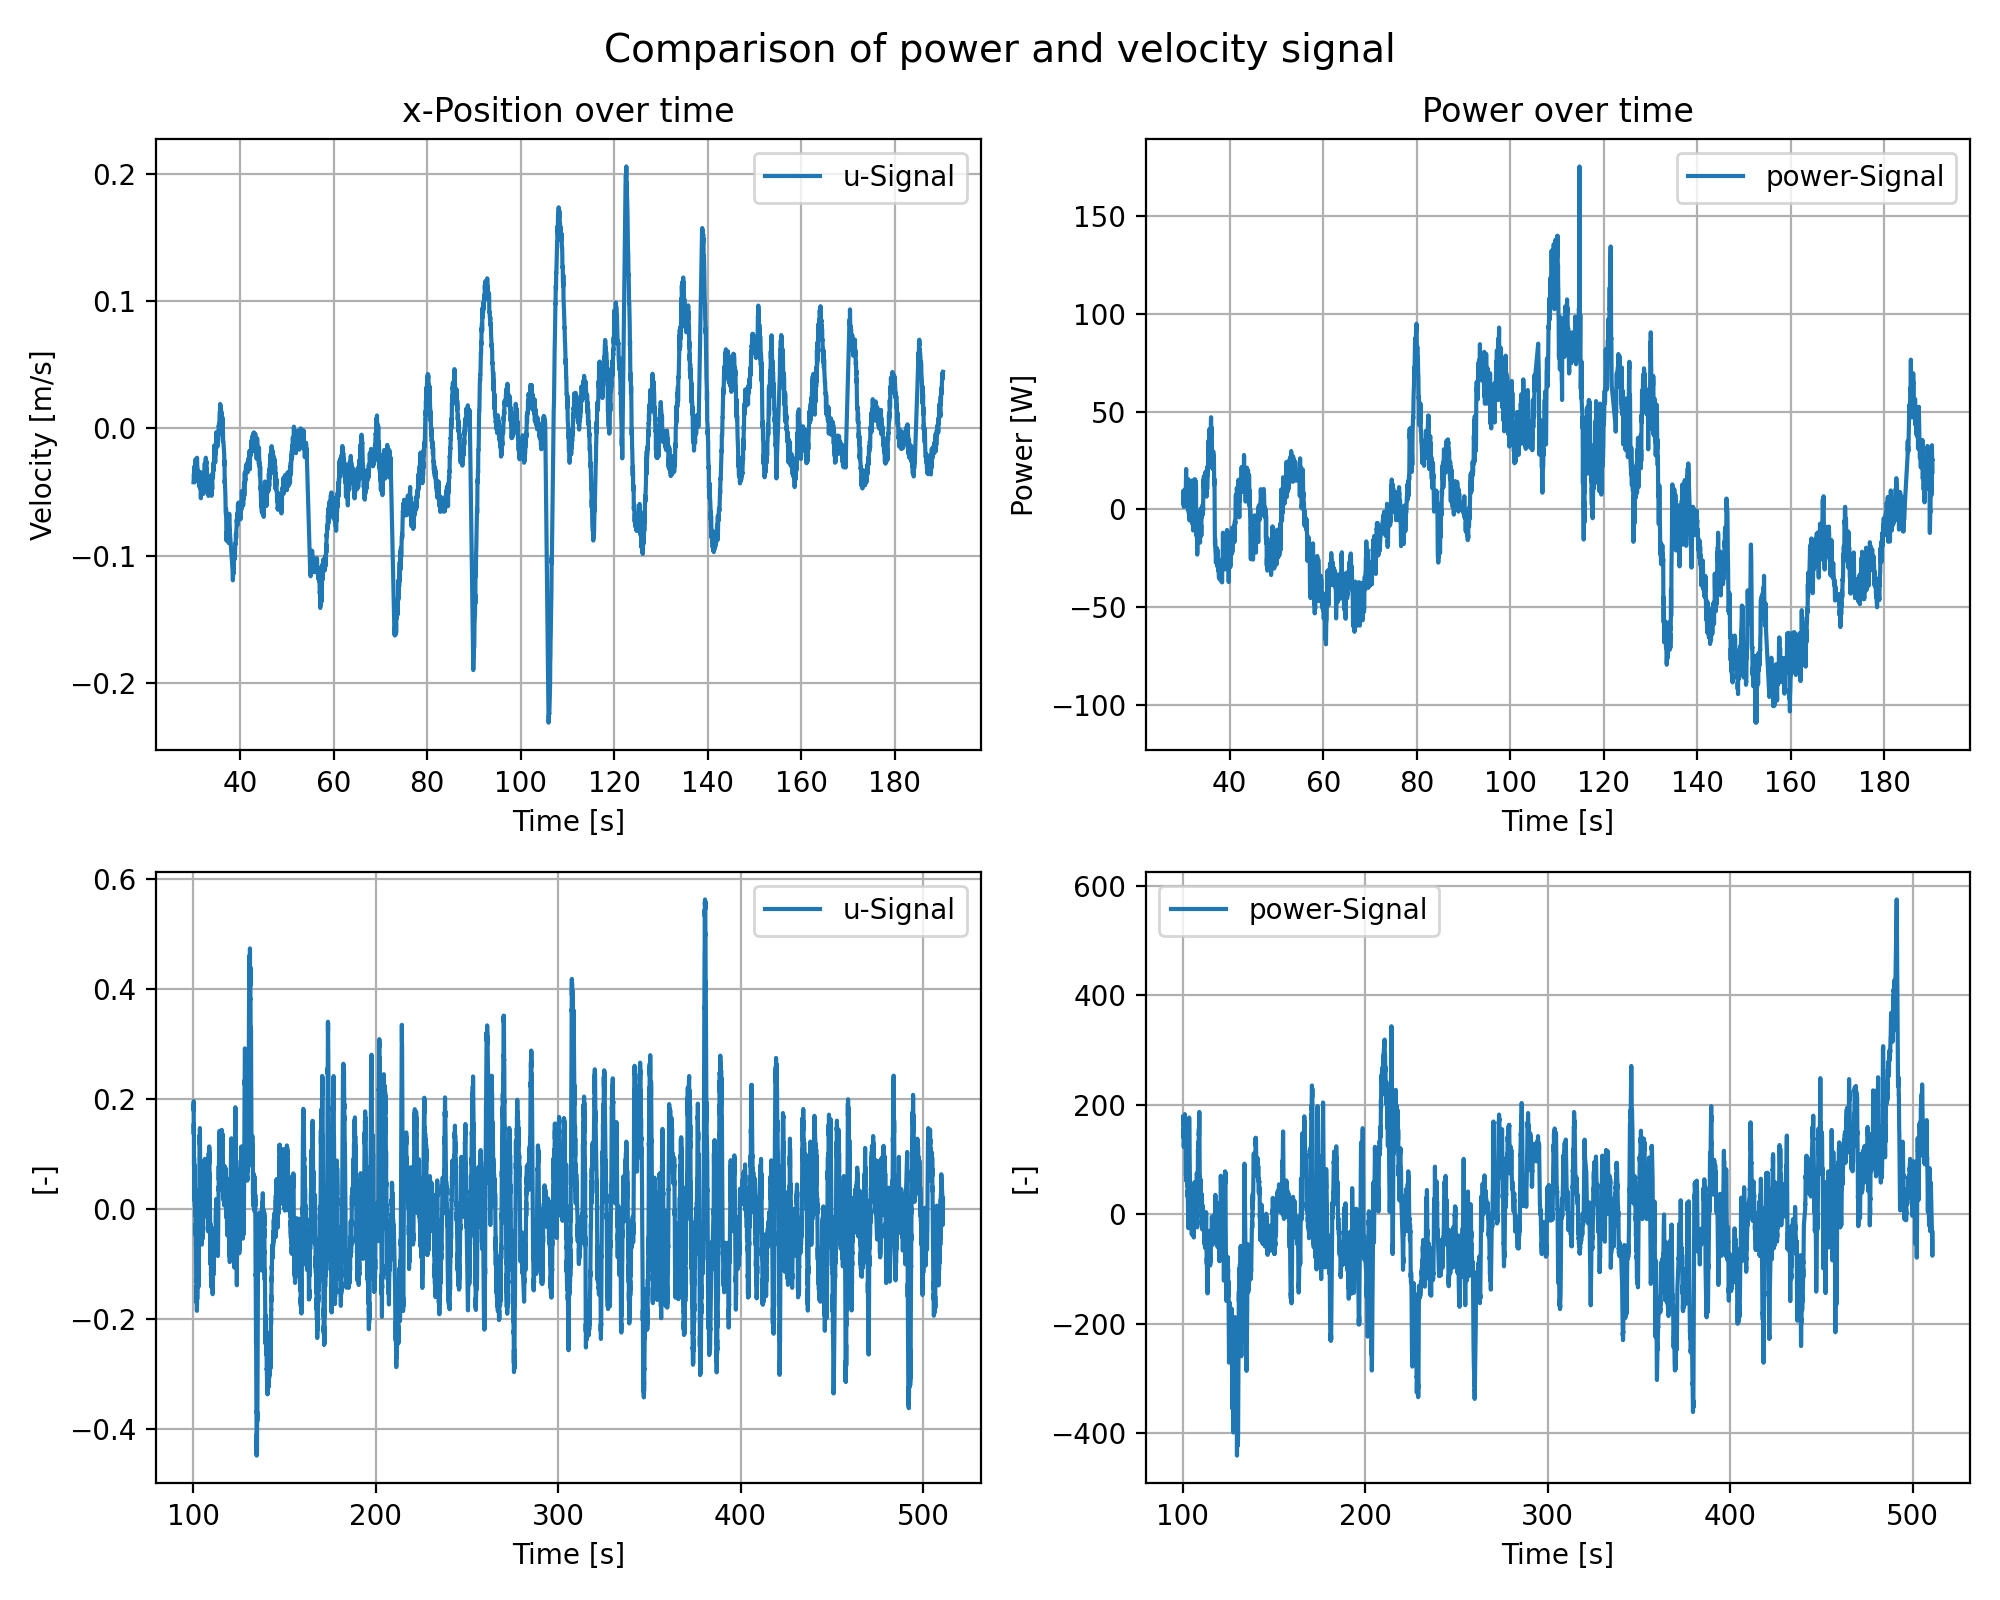

In [16]:
# Total power over time

fig0, ax0 = plt.subplots(2,2, figsize=(10,8))
fig0.suptitle('Comparison of power and velocity signal', fontsize=14)

# Rotor pairs
a = 0
b = -1
step = 1

cm = 'viridis'

# x-position
ax0[0][0].set_title(f'x-Position over time')
ax0[0][0].plot(fd_hover1['t'], fd_hover1['w'], label='u-Signal')
ax0[1][0].plot(fd_hover2['t'], fd_hover2['w'], label='u-Signal')

# y-position
ax0[0][1].set_title(f'Power over time')

ax0[0][1].plot(fd_hover1['t'], fd_hover1['pVehicle'] - fd_hover1['pVehicle'].mean(), label='power-Signal')
ax0[1][1].plot(fd_hover2['t'], fd_hover2['pVehicle'] - fd_hover2['pVehicle'].mean(), label='power-Signal')

for idx in range(4):
    
    i = int(idx/2)
    j = idx%2
    
    ax0[i][j].grid()
    ax0[i][j].set_xlabel('Time [s]')
    ax0[i][j].legend()

ax0[0][0].set_ylabel('Velocity [m/s]')
ax0[0][1].set_ylabel('Power [W]')
ax0[1][0].set_ylabel('[-]')
ax0[1][1].set_ylabel('[-]')

fig0.tight_layout()

# Regression model for power

## Linear model

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [18]:
for i in range(1,9):
    fd_hover1[f'pMo{i}'] = (fd_hover1[f'pMo{i}'] - fd_hover1[f'pMo{i}'].mean()) #/ fd_hover1[f'pMo{i}'].std()
    fd_hover2[f'pMo{i}'] = (fd_hover2[f'pMo{i}'] - fd_hover2[f'pMo{i}'].mean()) #/ fd_hover2[f'pMo{i}'].std()
    fd_hover[f'pMo{i}'] = (fd_hover[f'pMo{i}'] - fd_hover[f'pMo{i}'].mean()) #/ fd_hover[f'pMo{i}'].std()

In [19]:
fd_hover1['delta0^2'] = fd_hover1['delta0'] ** 2
fd_hover2['delta0^2'] = fd_hover2['delta0'] ** 2
fd_hover['delta0^2'] = fd_hover['delta0'] ** 2

In [20]:
# assemble features and y-values
featureSet1 = []
featureSet2 = []
featureSet3 = []

output = []

for i in range(1,9):
    featureSet1.append(f'uOut{i}')
    featureSet2.append(f'uOut{i}')
    featureSet3.append(f'uOut{i}')
    output.append(f'pMo{i}')

# add features to set 1
featureSet1.append('delta0^2')

# add features to set 2 
featureSet2.append('delta0^2')
#featureSet2.append('z')

# add features to set 3
featureSet3.append('delta0^2')
featureSet3.append('p')
featureSet3.append('q')

X1, X1_test, Y1, Y1_test = train_test_split(fd_hover1[featureSet1].copy(deep=True),
                                            fd_hover1[output].copy(deep=True),
                                            test_size=0.2, random_state=42)

X2, X2_test, Y2, Y2_test = train_test_split(fd_hover2[featureSet2].copy(deep=True),
                                            fd_hover2[output].copy(deep=True),
                                            test_size=0.2, random_state=42)

X3, X3_test, Y3, Y3_test = train_test_split(fd_hover[featureSet3].copy(deep=True),
                                            fd_hover[output].copy(deep=True),
                                            test_size=0.2, random_state=42)

X1_full = fd_hover1[featureSet1].copy(deep=True)
X2_full = fd_hover2[featureSet2].copy(deep=True)
X3_full = fd_hover[featureSet3].copy(deep=True)

Y1_full = fd_hover1[output].copy(deep=True)
Y2_full = fd_hover2[output].copy(deep=True)
Y3_full = fd_hover[output].copy(deep=True)

In [21]:
# Perform multiple linear regression
powerRegression1 = LinearRegression().fit(X1, Y1)

powerRegression2 = LinearRegression().fit(X2, Y2)

powerRegression3 = LinearRegression().fit(X3, Y3)

In [22]:
systemMatrix1 = powerRegression1.coef_.round(2)
systemMatrix2 = powerRegression2.coef_.round(2)
systemMatrix3 = powerRegression3.coef_.round(2)

bias1 = powerRegression1.intercept_
bias2 = powerRegression2.intercept_
bias3 = powerRegression3.intercept_

In [43]:
featureSet1

['uOut1',
 'uOut2',
 'uOut3',
 'uOut4',
 'uOut5',
 'uOut6',
 'uOut7',
 'uOut8',
 'delta0^2']

In [23]:
print('System maxtrix: Flight 1\n')
print(f'{systemMatrix1}')

System maxtrix: Flight 1

[[ 183.36   64.98   24.29   28.15   -4.34   -0.47  -41.16 -159.55   88.14]
 [  64.74  159.17   42.5    43.01  -10.69  -10.18 -126.84  -32.41   95.34]
 [  38.27   58.44  165.15   46.12   -3.55 -122.57  -15.87    4.3    88.84]
 [  41.71   47.73   59.9   160.03 -130.97  -30.85  -18.68  -12.66   94.02]
 [  45.72  124.19   47.16 -254.46  329.83   28.21  -48.82   29.65   44.19]
 [  34.04  135.   -181.28   -0.12  110.36  291.52  -24.76   76.2    55.17]
 [  57.6  -213.26   14.02   54.21    4.23   44.42  271.7     0.84   22.4 ]
 [-216.56   61.89   71.12    2.     59.4    -9.72   -0.49  277.95   -5.59]]


In [24]:
print('System maxtrix: Flight 2\n')

print(f'{systemMatrix2}')

System maxtrix: Flight 2

[[ 186.05   19.25    8.17   67.52   -9.77   49.58   38.5  -128.3    48.3 ]
 [  63.12  253.16   84.79   36.29   55.8     7.3  -161.07   28.97   82.06]
 [  12.97   47.61  188.56   72.17  -14.4  -130.79   10.15   44.79   72.86]
 [  55.43    4.24   29.45  140.84  -94.73   16.66   41.87   -9.32   70.46]
 [  27.01   32.92   34.49 -188.76  293.34   70.08   71.66   77.56   -8.21]
 [  58.12   14.42 -150.26   37.88   39.2   227.34   62.66   18.96    2.25]
 [  19.72 -122.45    2.09   54.12  -15.66   36.36  160.91   18.73   19.33]
 [-140.09   14.61   37.58   33.63   43.27   39.32   62.29  216.98    2.26]]


In [25]:
print('System maxtrix: Combined\n')
print(f'{systemMatrix3}')

System maxtrix: Combined

[[ 187.5    23.4    20.71   57.42    4.94   41.65   38.96 -125.14   42.96   53.21  -56.84]
 [  73.18  208.78   42.25   70.8   -12.18   16.37 -150.16  -14.56  106.58 -119.01  -71.67]
 [  15.24   48.76  188.75   65.73  -11.26 -134.28    5.71   39.23   76.64  -68.87   46.42]
 [  65.23    7.4    38.46  132.02  -75.06   18.5    49.57   -8.26   45.63   42.44   34.99]
 [  40.73   17.21   29.45 -189.92  286.73   67.36   79.6    56.08  -18.27 -131.19  -84.37]
 [  42.36    0.42 -199.82   82.89  -31.78  250.94   50.69    8.75   29.94   39.55  -65.3 ]
 [  23.74 -140.85   -9.9    68.61  -41.3    37.21  168.16    3.57   44.88   47.33   40.03]
 [-142.99   13.22   22.19   42.25   27.08   47.13   56.11  212.32    4.34  -95.81   74.59]]


In [26]:
print(f'{bias1}')

[103.29830417 117.59749198 123.95874628 112.28191058 -42.4420312  -75.01939047 -87.89145843 -32.96202322]


In [27]:
print(f'{bias2}')

[  75.49035907    1.03722877   67.97762452  102.17276056 -131.0682288     4.79702496   54.6364838    -3.80641812]


In [28]:
print(f'{bias3}')

[  78.38602319   57.33530033   82.35326395   97.94490427 -109.94280622  -10.39117793   24.76192754  -13.64297456]


In [29]:
yPredictionsTrain1 = X1.dot(systemMatrix1.T) + bias1
yPredictionsTrain2 = X2.dot(systemMatrix2.T) + bias2
yPredictionsTrain3 = X3.dot(systemMatrix3.T) + bias3

yPredictionsTest1 = X1_test.dot(systemMatrix1.T) + bias1
yPredictionsTest2 = X2_test.dot(systemMatrix2.T) + bias2
yPredictionsTest3 = X3_test.dot(systemMatrix3.T) + bias3

yPredictionsFull1 = X1_full.dot(systemMatrix1.T) + bias1
yPredictionsFull2 = X2_full.dot(systemMatrix2.T) + bias2
yPredictionsFull3 = X3_full.dot(systemMatrix3.T) + bias3

yPredictionsTrain1.columns = [f'pMo{i}' for i in range(1,9)]
yPredictionsTrain2.columns = [f'pMo{i}' for i in range(1,9)]
yPredictionsTrain3.columns = [f'pMo{i}' for i in range(1,9)]

yPredictionsTest1.columns = [f'pMo{i}' for i in range(1,9)]
yPredictionsTest2.columns = [f'pMo{i}' for i in range(1,9)]
yPredictionsTest3.columns = [f'pMo{i}' for i in range(1,9)]

yPredictionsFull1.columns = [f'pMo{i}' for i in range(1,9)]
yPredictionsFull2.columns = [f'pMo{i}' for i in range(1,9)]
yPredictionsFull3.columns = [f'pMo{i}' for i in range(1,9)]

In [30]:
# calculate prediction error

predictionErrorTrain1 = Y1 - yPredictionsTrain1
predictionErrorTrain2 = Y2 - yPredictionsTrain2
predictionErrorTrain3 = Y3 - yPredictionsTrain3

predictionErrorTest1 = Y1_test - yPredictionsTest1
predictionErrorTest2 = Y2_test - yPredictionsTest2
predictionErrorTest3 = Y3_test - yPredictionsTest3

predictionErrorFull1 = Y1_full - yPredictionsFull1
predictionErrorFull2 = Y2_full - yPredictionsFull2
predictionErrorFull3 = Y3_full - yPredictionsFull3

predictionErrorTrainMean1 = predictionErrorTrain1.rolling(30,1).mean()
predictionErrorTrainMean2 = predictionErrorTrain2.rolling(30,1).mean()
predictionErrorTrainMean3 = predictionErrorTrain3.rolling(30,1).mean()

predictionErrorTestMean1 = predictionErrorTest1.rolling(30,1).mean()
predictionErrorTestMean2 = predictionErrorTest2.rolling(30,1).mean()
predictionErrorTestMean3 = predictionErrorTest3.rolling(30,1).mean()

predictionErrorFullMean1 = predictionErrorFull1.rolling(30,1).mean()
predictionErrorFullMean2 = predictionErrorFull2.rolling(30,1).mean()
predictionErrorFullMean3 = predictionErrorFull3.rolling(30,1).mean()

# mean absolute error
MAE1 = np.around(mean_absolute_error(Y1, yPredictionsTrain1, multioutput='raw_values'),2)
MAE2 = np.around(mean_absolute_error(Y2, yPredictionsTrain2, multioutput='raw_values'),2)
MAE3 = np.around(mean_absolute_error(Y3, yPredictionsTrain3, multioutput='raw_values'),2)

MAE1_test = np.around(mean_absolute_error(Y1_test, yPredictionsTest1, multioutput='raw_values'),2)
MAE2_test = np.around(mean_absolute_error(Y2_test, yPredictionsTest2, multioutput='raw_values'),2)
MAE3_test = np.around(mean_absolute_error(Y3_test, yPredictionsTest3, multioutput='raw_values'),2)

MAE1_full = np.around(mean_absolute_error(Y1_full, yPredictionsFull1, multioutput='raw_values'),2)
MAE2_full = np.around(mean_absolute_error(Y2_full, yPredictionsFull2, multioutput='raw_values'),2)
MAE3_full = np.around(mean_absolute_error(Y3_full, yPredictionsFull3, multioutput='raw_values'),2)

In [31]:
print('MAE training flight 1: ' + str(MAE1))
print('MAE training flight 2: ' + str(MAE2))
print('MAE training combined: ' + str(MAE3))

print("")

print('MAE test flight 1: ' + str(MAE1_test))
print('MAE test flight 2: ' + str(MAE2_test))
print('MAE test combined: ' + str(MAE3_test))

print("")

print('MAE total flight 1: ' + str(MAE1_full))
print('MAE total flight 2: ' + str(MAE2_full))
print('MAE total combined: ' + str(MAE3_full))

MAE training flight 1: [4.46 3.98 3.5  4.28 6.77 9.58 7.32 6.66]
MAE training flight 2: [ 9.91 12.22 10.54  8.13 15.23 11.26  9.78 11.9 ]
MAE training combined: [ 8.74 11.17  8.14 10.49 12.75 13.23 11.49  9.13]

MAE test flight 1: [4.47 4.02 3.52 4.31 6.57 9.73 7.3  6.72]
MAE test flight 2: [ 9.81 12.46 10.4   8.35 15.37 11.21  9.59 11.68]
MAE test combined: [ 8.88 11.58  8.4  10.6  12.72 13.76 11.74  9.39]

MAE total flight 1: [4.46 3.99 3.5  4.29 6.73 9.61 7.32 6.67]
MAE total flight 2: [ 9.89 12.27 10.51  8.17 15.26 11.25  9.74 11.86]
MAE total combined: [ 8.77 11.25  8.19 10.51 12.75 13.34 11.54  9.19]


In [32]:
predictionErrorFull1.corr()

pMo1      pMo2      pMo3      pMo4      pMo5      pMo6      pMo7  \
pMo1  1.000000 -0.173738  0.314967 -0.190061  0.425864 -0.007307  0.398272   
pMo2 -0.173738  1.000000 -0.359672  0.503172 -0.045555  0.279950 -0.178957   
pMo3  0.314967 -0.359672  1.000000 -0.227459  0.347099 -0.116204  0.299391   
pMo4 -0.190061  0.503172 -0.227459  1.000000 -0.140324  0.366542 -0.074846   
pMo5  0.425864 -0.045555  0.347099 -0.140324  1.000000 -0.202177  0.323255   
pMo6 -0.007307  0.279950 -0.116204  0.366542 -0.202177  1.000000 -0.361477   
pMo7  0.398272 -0.178957  0.299391 -0.074846  0.323255 -0.361477  1.000000   
pMo8 -0.105557  0.356345 -0.015022  0.350768 -0.170258  0.558567 -0.280244   

          pMo8  
pMo1 -0.105557  
pMo2  0.356345  
pMo3 -0.015022  
pMo4  0.350768  
pMo5 -0.170258  
pMo6  0.558567  
pMo7 -0.280244  
pMo8  1.000000

<IPython.core.display.Javascript object>


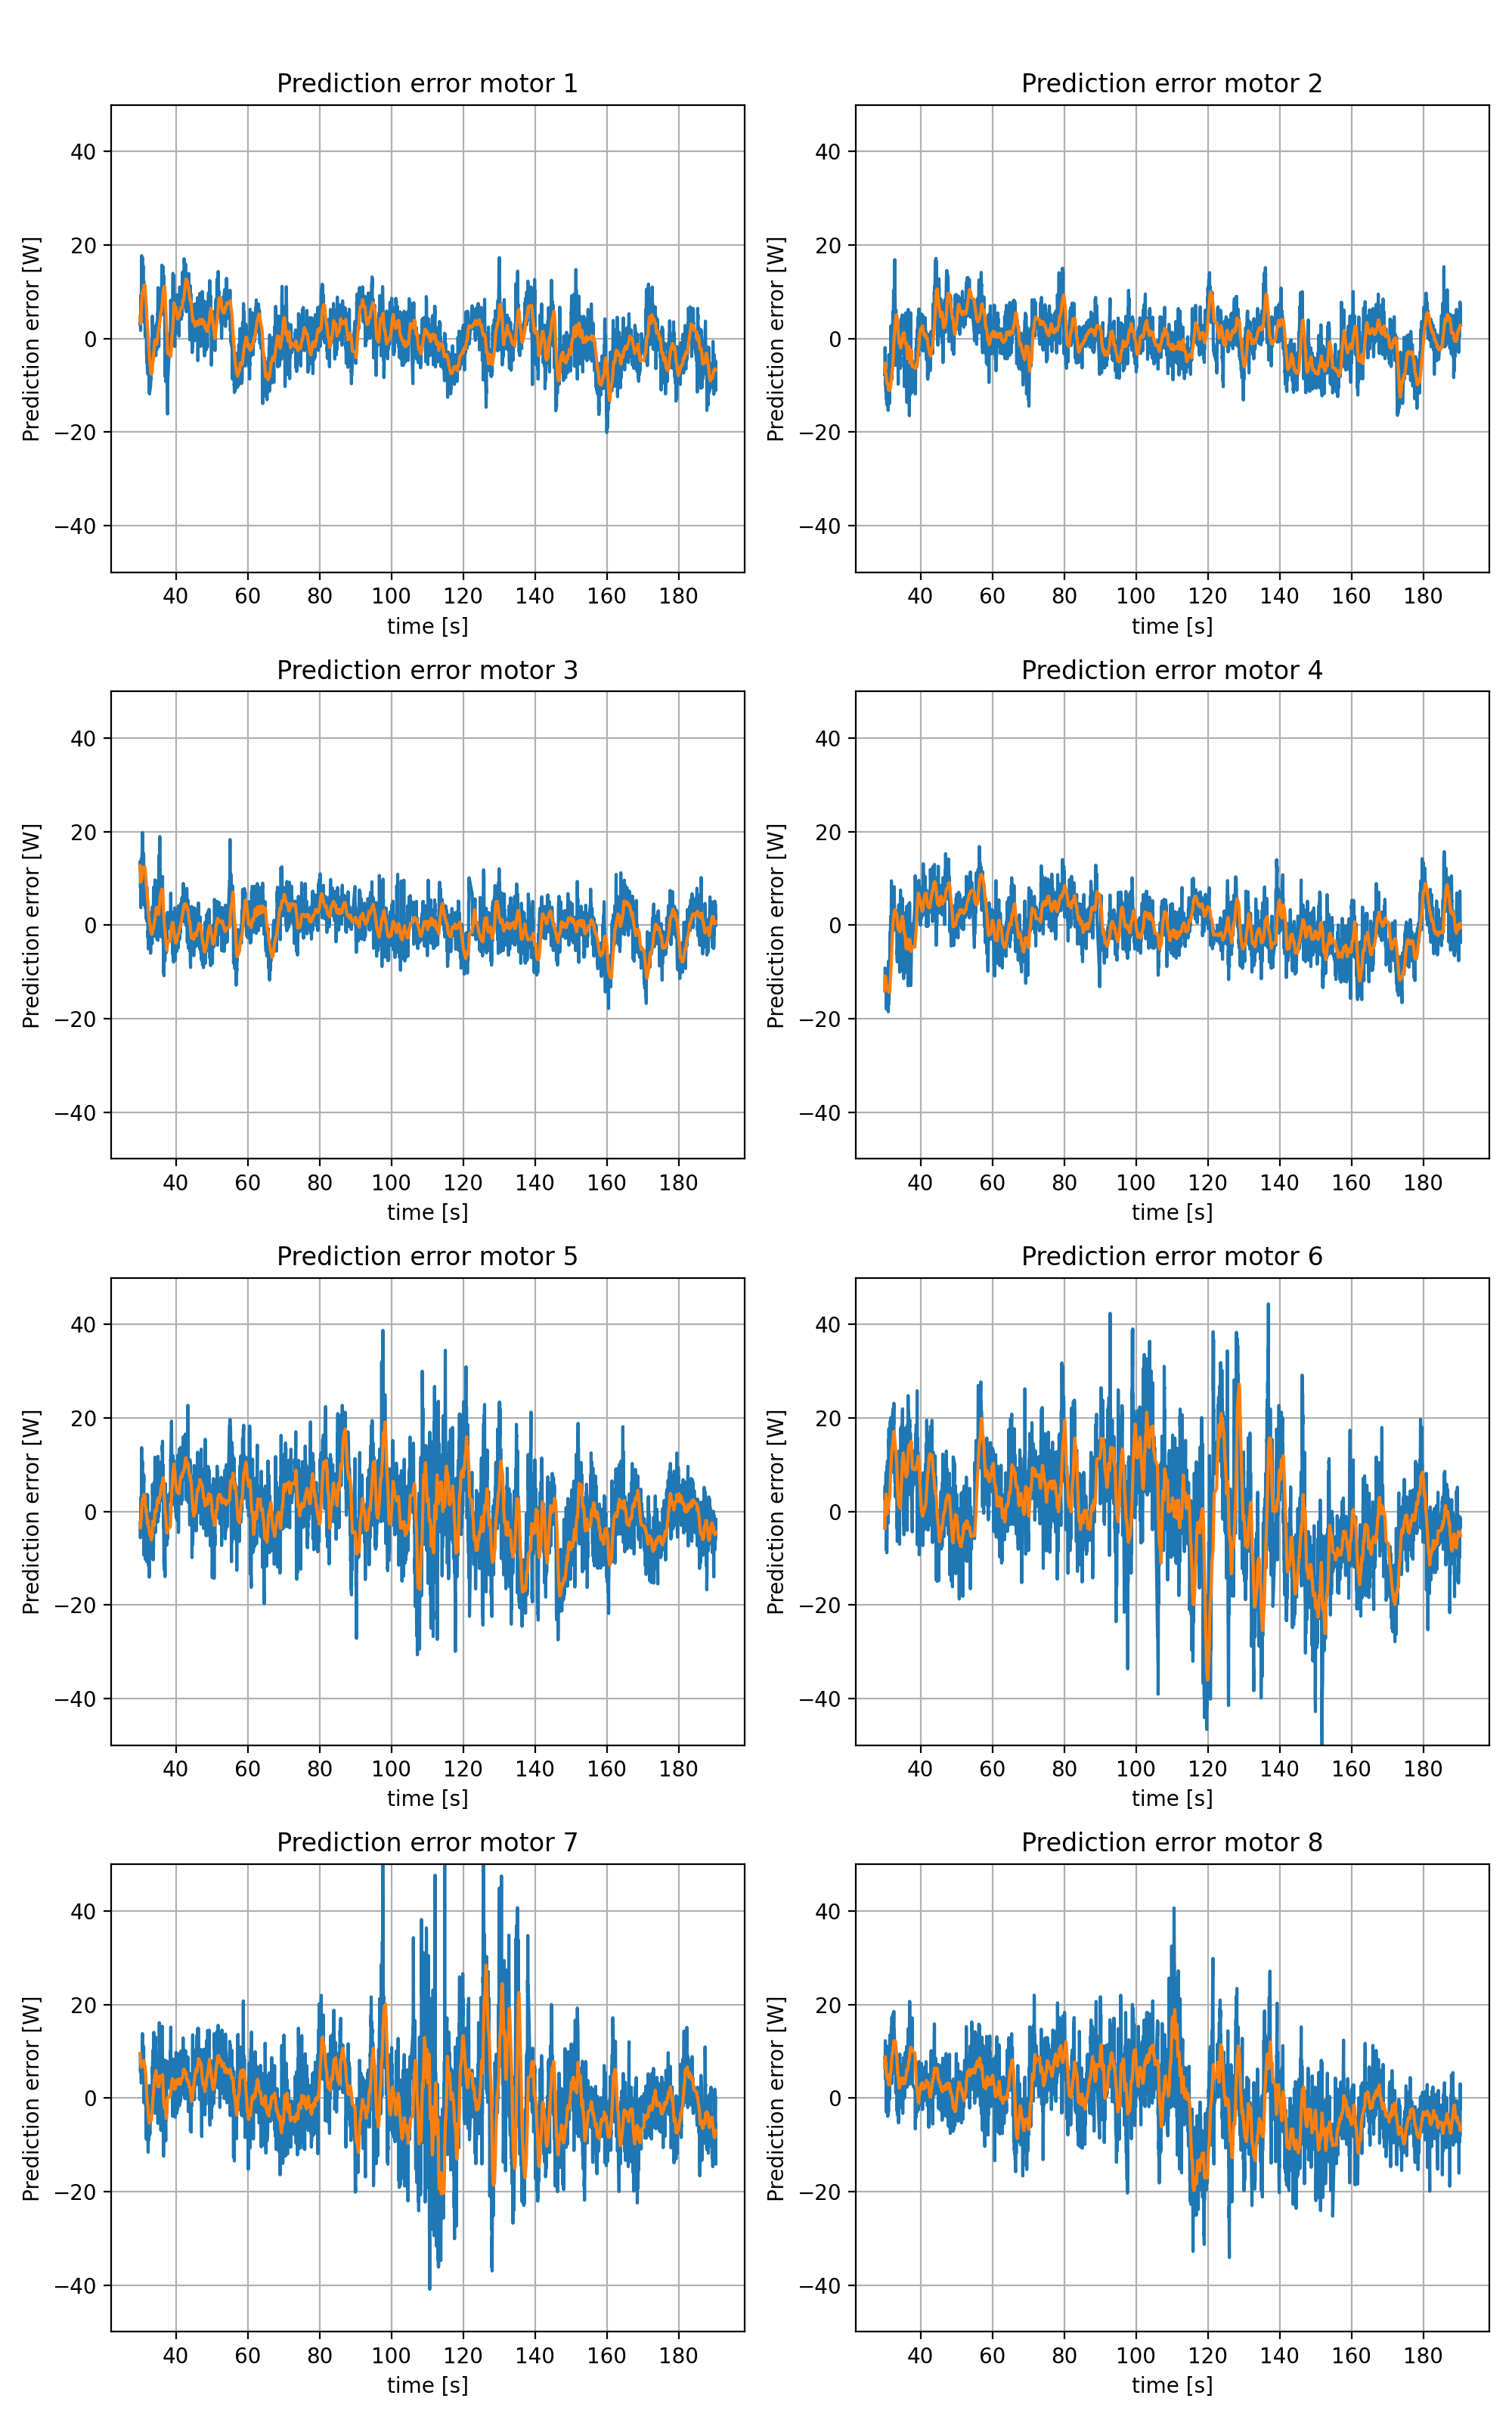

In [33]:
# plot power over time

fig2, ax2 = plt.subplots(4, 2, figsize=(10,16))
fig2.suptitle('Coparison between predicted and true motor power', fontsize=14, y=1.05)

for idx in range(8):
    
    i = int(idx/2)
    j = idx % 2
    
    ax2[i][j].plot(fd_hover1['t'], predictionErrorFull1[f'pMo{idx+1}'])
    ax2[i][j].plot(fd_hover1['t'], predictionErrorFullMean1[f'pMo{idx+1}'])

    ax2[i][j].set_title(f'Prediction error motor {idx+1}')
    
    ax2[i][j].set_ylim(-50,50)
    ax2[i][j].set_xlabel('time [s]')
    ax2[i][j].set_ylabel('Prediction error [W]')
    ax2[i][j].grid()

fig2.tight_layout()

<IPython.core.display.Javascript object>


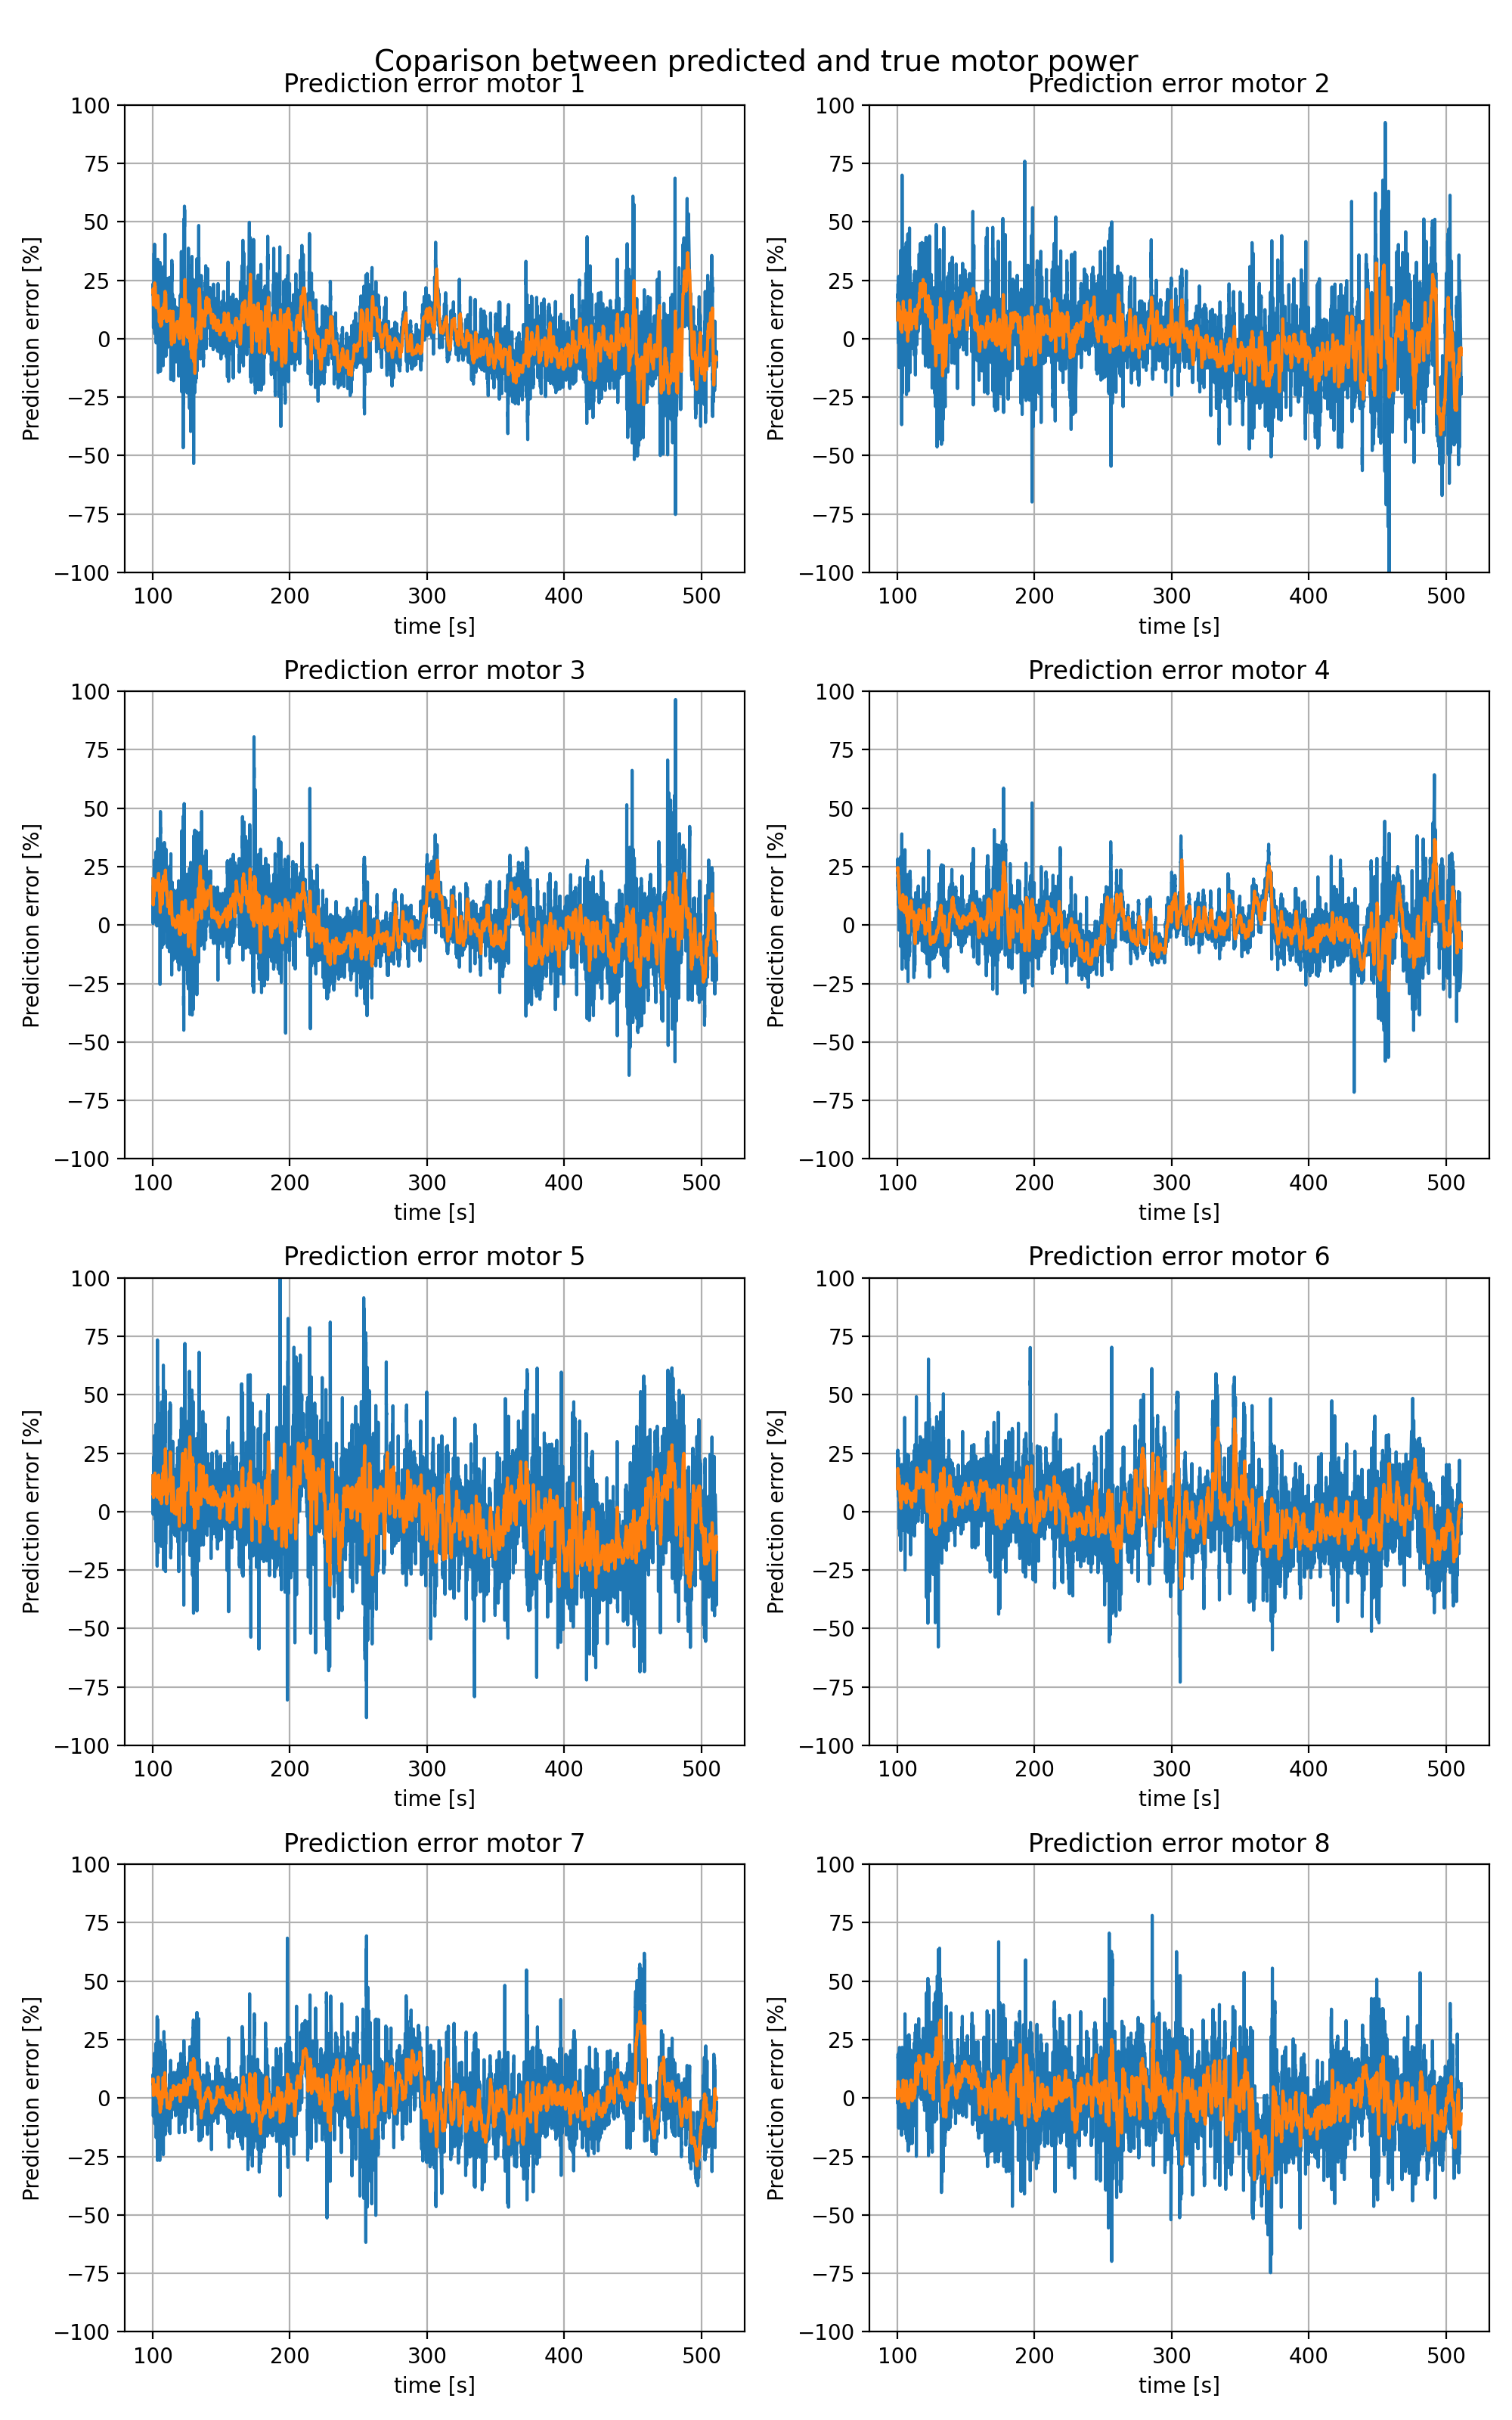

In [34]:
# plot power over time

fig3, ax3 = plt.subplots(4, 2, figsize=(10,16))
fig3.suptitle('Coparison between predicted and true motor power', fontsize=14)

for idx in range(8):
    
    i = int(idx/2)
    j = idx % 2
    
    ax3[i][j].plot(fd_hover2['t'], predictionErrorFull2[f'pMo{idx+1}'])
    ax3[i][j].plot(fd_hover2['t'], predictionErrorFullMean2[f'pMo{idx+1}'])

    ax3[i][j].set_title(f'Prediction error motor {idx+1}')
    
    ax3[i][j].set_ylim(-100,100)
    ax3[i][j].set_xlabel('time [s]')
    ax3[i][j].set_ylabel('Prediction error [%]')
    
    ax3[i][j].grid()

fig3.tight_layout()

<IPython.core.display.Javascript object>


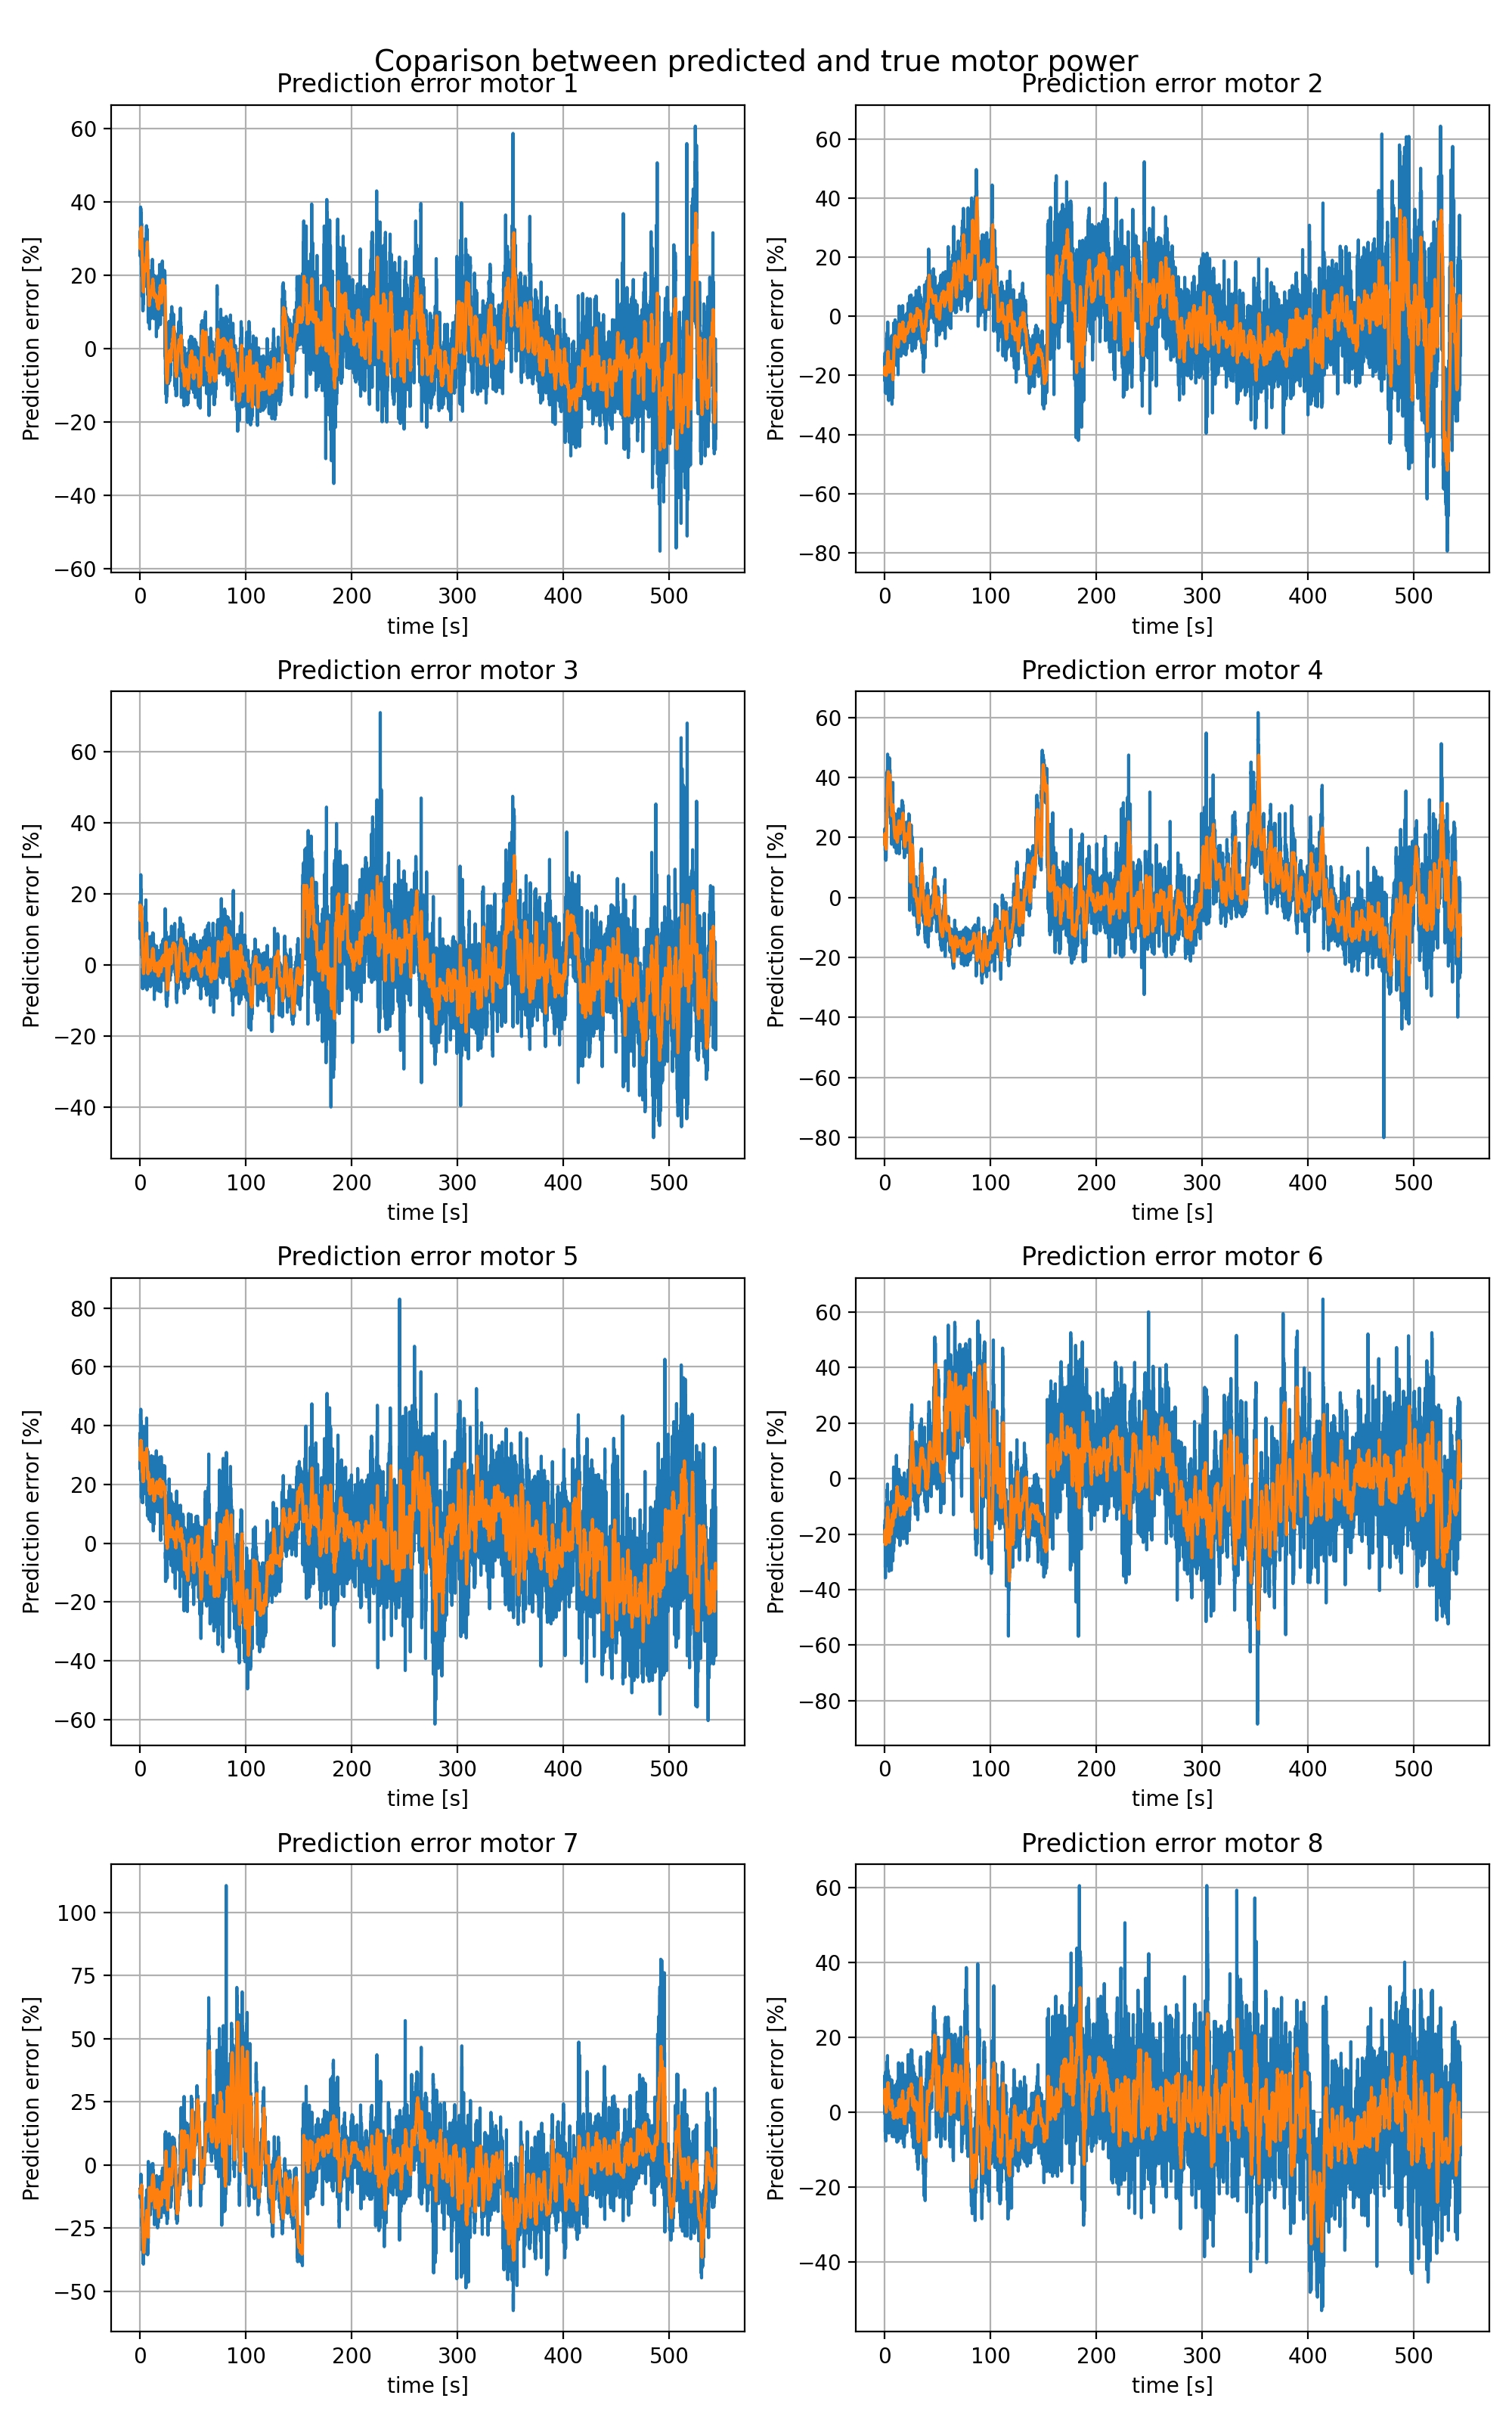

In [35]:
# plot power over time

fig4, ax4 = plt.subplots(4, 2, figsize=(10,16))
fig4.suptitle('Coparison between predicted and true motor power', fontsize=14)

for idx in range(8):
    
    i = int(idx/2)
    j = idx % 2
    
    ax4[i][j].plot(fd_hover['t'], predictionErrorFull3[f'pMo{idx+1}'])
    ax4[i][j].plot(fd_hover['t'], predictionErrorFullMean3[f'pMo{idx+1}'])

    ax4[i][j].set_title(f'Prediction error motor {idx+1}')
    
    #ax4[i][j].set_ylim(-100,100)
    ax4[i][j].set_xlabel('time [s]')
    ax4[i][j].set_ylabel('Prediction error [%]')
    
    ax4[i][j].grid()

fig4.tight_layout()

In [36]:
fdHover = fd_hover.copy(deep=True)

In [37]:
fdHover.update(predictionErrorFull3)

In [38]:
predictionErrorFull3

pMo1       pMo2       pMo3       pMo4       pMo5       pMo6  \
900    29.636265 -17.689931  15.835155  17.751555  32.267462 -22.818480   
901    27.259317 -21.942216  17.794361  21.741175  28.884675 -22.990817   
902    25.206228 -13.718438  13.790091  22.178744  25.092421 -17.810879   
903    28.014793 -16.401618  10.798930  22.978403  26.718319 -18.568083   
904    25.727353 -19.139762  12.708701  21.803423  29.945348 -16.685821   
...          ...        ...        ...        ...        ...        ...   
15295 -12.129627   0.573809 -21.567860 -13.355148 -27.402322  12.736499   
15296 -15.378546 -11.599709 -20.152477  -9.885260 -38.184262   5.341281   
15297  -4.224441 -10.020085 -19.016152 -14.257719 -21.025251   4.399222   
15298  -6.267327 -11.560499 -14.615831 -13.504046 -19.377948  -3.542410   
15299  -7.606714 -12.609326 -11.076085 -14.136472 -20.067470  -1.136905   

            pMo7      pMo8  
900   -10.608780  2.397268  
901    -9.794280  4.360583  
902    -9.256122  8.774282  
903   -10.011608  4.904509  
904    -9.470159  9.845012  
...          ...       ...  
15295  -1.601706  3.468111  
15296   1.816284  6.846951  
15297  -1.245393 -6.923810  
15298   0.520212 -1.704175  
15299   0.354082  0.060169  

[16320 rows x 8 columns]

In [39]:
fdHover.corr()['pMo2'].abs().sort_values(ascending=False).head(60)

pMo2           1.000000
pMo6           0.475451
pMo7           0.398902
pMo4           0.385040
pMo8           0.260951
pVehicle       0.243200
t              0.183985
U7             0.165953
U4             0.164728
U8             0.164021
U3             0.162392
U1             0.140565
U5             0.140172
U6             0.139218
pMo5           0.138297
pArm2          0.132858
pArm1          0.131792
U2             0.130823
I2             0.129977
w              0.097262
I4             0.091804
v              0.091520
I6             0.079440
pArm3          0.073604
I7             0.065644
x              0.063217
y              0.057584
rpm6           0.047571
z              0.046292
rpm8           0.042889
u              0.041987
I5             0.041981
r              0.040198
pMo1           0.039084
I8             0.028872
rpm4           0.022932
dRpmArm2       0.018565
dRpmArm4       0.017932
dRpmArm3       0.017815
pArm4          0.013470
rpm2           0.013173
uIn4           0

-> Correlated with other CCW motors

In [40]:
fdHover.corr()['pVehicle'].abs().sort_values(ascending=False).head(60)

pVehicle       1.000000
pArm2          0.538452
pArm3          0.526212
uIn4           0.430281
pArm4          0.395299
I4             0.354613
uOut4          0.286006
I1             0.257589
rpm4           0.256183
pMo2           0.243200
uIn3           0.229373
I3             0.219954
pMo6           0.219924
p              0.198533
uIn1           0.193747
I2             0.192407
U7             0.189551
U4             0.188989
U8             0.186034
U3             0.185962
pMo1           0.185493
pMo3           0.185405
I6             0.177738
uIn2           0.177038
pMo8           0.173028
pMo5           0.169310
delta0^2       0.167396
I7             0.158808
pArm1          0.156667
uOut1          0.154590
uOut7          0.153853
uOut6          0.153075
x              0.151963
z              0.148868
y              0.143470
pMo7           0.141289
rpm7           0.138988
v              0.138419
rpm6           0.137018
w              0.127156
rpm8           0.126468
uOut8          0

In [41]:
fdHover.columns

Index(['t', 'x', 'y', 'z', 'u', 'v', 'w', 'p', 'q', 'r', 'U1', 'U2', 'U3',
       'U4', 'U5', 'U6', 'U7', 'U8', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7',
       'I8', 'rpm1', 'rpm2', 'rpm3', 'rpm4', 'rpm5', 'rpm6', 'rpm7', 'rpm8',
       'uIn1', 'uIn2', 'uIn3', 'uIn4', 'uOut1', 'uOut2', 'uOut3', 'uOut4',
       'uOut5', 'uOut6', 'uOut7', 'uOut8', 'delta0', 'pMo1', 'pMo2', 'pMo3',
       'pMo4', 'pMo5', 'pMo6', 'pMo7', 'pMo8', 'dRpmArm1', 'dRpmArm2',
       'dRpmArm3', 'dRpmArm4', 'dRpmVehicle', 'pArm1', 'pArm2', 'pArm3',
       'pArm4', 'pVehicle', 'delta0^2'],
      dtype='object')